# Thermal Exploration using TidalPy
In this notebook we will see how we can use TidalPy's object oriented approach to build a layered planet. We will then apply different temperatures to its mantle layer and see how its physical properties change.

### Build the Planet
For this example we will build a simple version of Io. We will be using the pre-built TidalPy configuration for "io_simple"; its configurations will be printed below.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from TidalPy import build_world, build_from_world
from TidalPy import Orbit

In [2]:
%matplotlib notebook

In [3]:
from pprint import pprint
io = build_world('io_simple')
pprint(io.Mantle.rheology.partial_melting_model.config)

{'crit_melt_frac': 0.5,
 'crit_melt_frac_width': 0.05,
 'fs_shear_power_phase': 40.6,
 'fs_shear_power_slope': 82000.0,
 'fs_visc_power_phase': 1.0,
 'fs_visc_power_slope': 27000.0,
 'hn_shear_falloff_slope': 700.0,
 'hn_shear_param_1': 40000.0,
 'hn_shear_param_2': 25.0,
 'hn_visc_slope_1': 13.5,
 'hn_visc_slope_2': 370.0,
 'liquid_shear': 1e-05,
 'liquidus': 2000.0,
 'model': 'henning',
 'solidus': 1600.0}


### Plot the Planet's Interior Structure
Remember this is just a simple version of Io (no density as function of pressure)

<IPython.core.display.Javascript object>


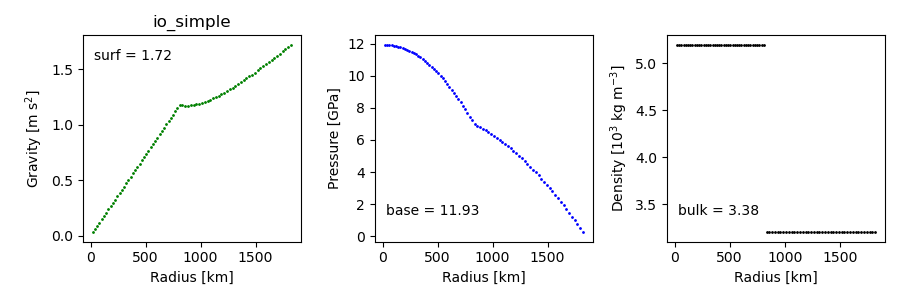

<IPython.core.display.Javascript object>


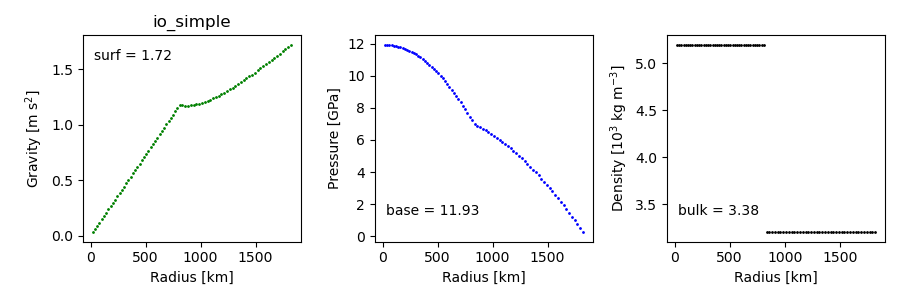

In [4]:
io.paint()

### Set the Mantle's Temperature and Plot its Viscoelastic Properties

<IPython.core.display.Javascript object>


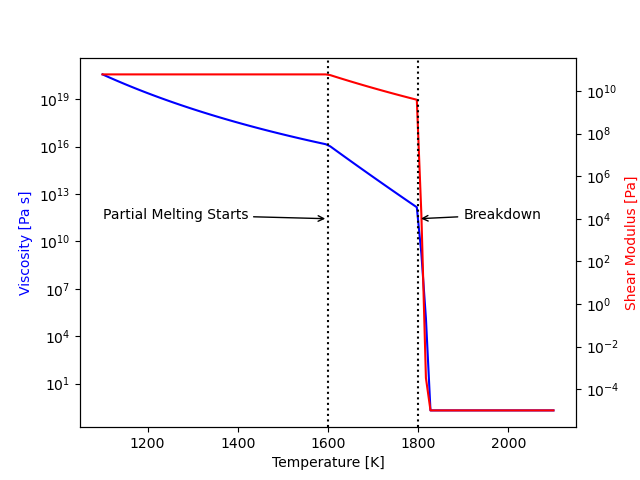

In [5]:
temperature = np.linspace(1100., 2100., 100)
io.Mantle.set_state(temperature=temperature)

# Plot the results
fig, ax = plt.subplots()
ax.set(xlabel='Temperature [K]', ylabel='Viscosity [Pa s]', yscale='log')
ax.yaxis.label.set_color('b')
ax_2 = ax.twinx()
ax_2.set(yscale='log', ylabel='Shear Modulus [Pa]')
ax_2.yaxis.label.set_color('r')
ax.plot(temperature, io.Mantle.viscosity, c='b')
ax_2.plot(temperature, io.Mantle.shear_modulus, c='r')

# Add line where partial melting starts
ax_2.axvline(x=1600., ls=':', c='k')
ax_2.annotate('Partial Melting Starts', (1600., 1.e4), (1100, 1.e4), arrowprops={'arrowstyle':'->'})
ax_2.axvline(x=1800., ls=':', c='k')
ax_2.annotate('Breakdown', (1800., 1.e4), (1900, 1.e4), arrowprops={'arrowstyle':'->'})
plt.show()

## Calculate Tidal Heating as a function of Temperature for Io
Using a more realistic interior model for Io, we will now calculate tidal heating as a function of mantle temperature.
This assumes Io's mantle is a homogeneous layer that follows the shear & viscosity vs. temperature relationship seen in the last figure.

<IPython.core.display.Javascript object>


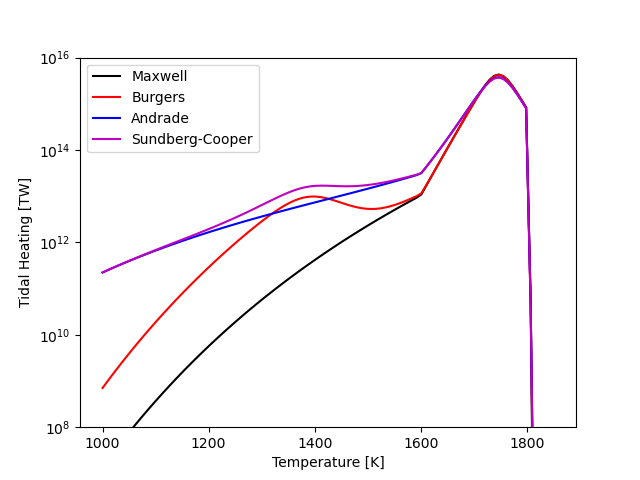

Set state called for Orbit (PhysicsOrbit, Host: jupiter) included a stellar orbit change but no star set. Skipping.
Set state called for Orbit (PhysicsOrbit, Host: jupiter) included a stellar orbit change but no star set. Skipping.
Set state called for Orbit (PhysicsOrbit, Host: jupiter) included a stellar orbit change but no star set. Skipping.
Set state called for Orbit (PhysicsOrbit, Host: jupiter) included a stellar orbit change but no star set. Skipping.


In [6]:
# Build the new Io and its tidal host, Jupiter.
io_base = build_world('io')
jupiter = build_world('jupiter')

# Setup domain and plot
temperature = np.linspace(1000., 1850., 100)
fig2, ax2 = plt.subplots()
ax2.set(xlabel='Temperature [K]', ylabel='Tidal Heating [W]', yscale='log', ylim=(1e8, 1e16))

# Lets show how different rheological models can impact tidal heating
rheologies = {
    'maxwell': ('Maxwell', 'k'),
    'burgers': ('Burgers', 'r'),
    'andrade': ('Andrade', 'b'),
    'sundberg': ('Sundberg-Cooper', 'm')
}
orbit_by_rheo = {}

for rheo_model, (rheo_name, rheo_color) in rheologies.items():
    
    # Build a new Io assuming its mantle has this new rheology.
    #    Note: Building a whole new world just to see the difference in
    #       in rheology is overkill - this is just a demonstration.
    new_config = {'layers': {'Mantle': {'rheology': {'complex_compliance': {'model': rheo_model}}}}}
    io = build_from_world(io_base, new_config=new_config)
    
    # Load in temperatures and make tidal calculations
    io.mantle.temperature = temperature
    
    # Add orbit with jupiter (load in default orbital configurations based on Io's config)
    orbit = Orbit(tidal_host=deepcopy(jupiter), tidal_bodies=io)
    orbit_by_rheo[(rheo_name, rheo_color)] = orbit
    
    # Plot results
    ax2.plot(temperature, io.tidal_heating_global, label=rheo_name, color=rheo_color)
    
ax2.legend(loc='best')
plt.show()

## Calculate Tidal Heating as a function of Strength
The specific viscosity and shear modulus relationships used in the above example are full of uncertainties. Especially since we did not consider presssure dependence.
However, the relationship between tidal heating and viscosity and shear modulus is less uncertain (still lots more work needed!). Let us look at that phase space, ignoring temperature

<IPython.core.display.Javascript object>


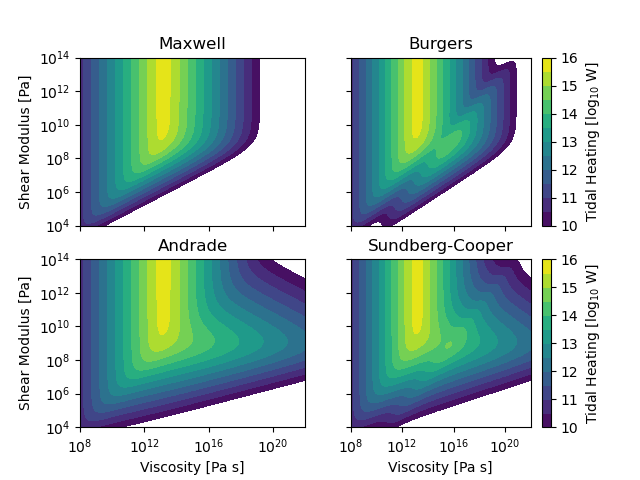

In [14]:
# Setup Plot
fig3, axis_set = plt.subplots(nrows=2, ncols=2, sharex='all', sharey='all')
((ax3_1, ax3_2), (ax3_3, ax3_4)) = axis_set
ax3_1.set(xlabel='', xscale='log', ylabel='Shear Modulus [Pa]', yscale='log')
ax3_2.set(xlabel='', xscale='log', ylabel='', yscale='log')
ax3_3.set(xlabel='Viscosity [Pa s]', xscale='log', ylabel='Shear Modulus [Pa]', yscale='log')
ax3_4.set(xlabel='Viscosity [Pa s]', xscale='log', ylabel='', yscale='log')
axes = [ax3_1, ax3_2, ax3_3, ax3_4]

viscosity_array = np.logspace(8, 22, 100)
shear_array = np.logspace(4, 14, 110)

# We eventually want a 2D matrix to plot the results, 
#    but currently TidalPy relies on numba which does not support 2D arrays - so we will need
#    to flatten them before calculations.
viscosity_mtx, shear_mtx = np.meshgrid(viscosity_array, shear_array)
shape = viscosity_mtx.shape
viscosity_mtx_flat = viscosity_mtx.flatten()
shear_mtx_flat = shear_mtx.flatten()

# Colorbar slices
colorbar_points = np.linspace(10, 16, 13)

# Use the orbits constructed in the last example
i = 0
for (rheo_name, rheo_color), orbit in orbit_by_rheo.items():
    
    # Set the strength of the mantle and perform tidal calculations
    io = orbit.tidal_objects[1]
    io.mantle.set_strength(viscosity=viscosity_mtx_flat, shear_modulus=shear_mtx_flat)
    
    # Pull out tidal heating and convert the shape
    tidal_heating = io.tidal_heating_global
    tidal_heating = np.log10(tidal_heating.reshape(shape))
    
    # Plot results
    cb_data = axes[i].contourf(viscosity_array, shear_array, tidal_heating, colorbar_points)
    axes[i].set_title(rheo_name)
    
    if i in [1, 3]:
        cb = plt.colorbar(cb_data, ax=axes[i])
        cb.set_label('Tidal Heating [log$_{10}$ W]') 
    i += 1
    
plt.show()